In [1]:
import pickle
import re
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

from utils_martina.my_utils import *

In [28]:
# Set patient and record
patient_id = "chb04"
record_id = "28"

In [29]:
logs_path = "..\\..\\explainability\GRETEL-repo\\output\\logs\\"
eval_manager_path = "..\\..\\explainability\GRETEL-repo\\output\\eval_manager\\"

In [30]:
file_name = get_most_recent_file(eval_manager_path)
print(file_name)

21076-Martina.pkl


## Caricamento eval_manager

In [31]:
# Carica eval_manager da file
with open(eval_manager_path + file_name, 'rb') as f:
    eval_manager = pickle.load(f)

In [32]:
# Stampa caratteristiche modello
print("MODEL:")
print(eval_manager._evaluators[0]._oracle.model)

print("\nMODEL PARAMETERS:")
model = eval_manager._evaluators[0]._oracle.model

for name, param in model.named_parameters():
    print(f"Parameter: {name}, Shape: {param.shape}")
    print(param)  # Se vuoi stampare anche i valori dei parametri
    print("")

MODEL:
DownstreamGCN(
  (pooling): MeanAggregation()
  (graph_convs): Sequential(
    (0): GCNConv(1, 2)
    (1): GCNConv(2, 2)
    (2): MeanAggregation()
  )
  (downstream_layers): Sequential(
    (0): Linear(in_features=2, out_features=2, bias=True)
  )
)

MODEL PARAMETERS:
Parameter: graph_convs.0.bias, Shape: torch.Size([2])
Parameter containing:
tensor([-0.0757, -0.0701], dtype=torch.float64, requires_grad=True)

Parameter: graph_convs.0.lin.weight, Shape: torch.Size([2, 1])
Parameter containing:
tensor([[-2.0421],
        [-1.8928]], dtype=torch.float64, requires_grad=True)

Parameter: graph_convs.1.bias, Shape: torch.Size([2])
Parameter containing:
tensor([-0.0019, -0.0029], dtype=torch.float64, requires_grad=True)

Parameter: graph_convs.1.lin.weight, Shape: torch.Size([2, 2])
Parameter containing:
tensor([[0.5741, 1.9417],
        [1.3598, 1.9921]], dtype=torch.float64, requires_grad=True)

Parameter: downstream_layers.0.weight, Shape: torch.Size([2, 2])
Parameter containing:


## Visualizzazione dei risultati

In [33]:
def get_oracle_and_explainer_names(eval_manager):
    string = eval_manager.evaluators[0].name

    oracle_name = re.search(r'using_(.*?)Oracle', string).group(1)
    if oracle_name == '': # Da controllare se è vero
        oracle_name = 'GCN'
    explainer_name = re.search(r'for_(.*?)Explainer', string).group(1)

    return f"{oracle_name} oracle - {explainer_name} explainer"

In [34]:
with open(f"EEG_data\mid_points_{patient_id}_{record_id}.pkl", 'rb') as f:
    fixed_positions = pickle.load(f)

In [35]:
# Funzione aggiornata per disegnare la differenza tra i grafi (modificata per funzionare con animate)
def plot_graph_difference_updated(A_orig, A_expl, axs, fixed_positions):
    # Crea grafi da matrici di adiacenza
    G_orig = nx.from_numpy_array(A_orig)
    G_expl = nx.from_numpy_array(A_expl)

    # Differenza tra le matrici di adiacenza
    A_differenza = A_orig - A_expl
    archi_aggiunti = nx.from_numpy_array(A_differenza == -1)
    archi_rimossi = nx.from_numpy_array(A_differenza == 1)

    # Disegna il grafo originario
    nx.draw(G_orig, ax=axs[0], pos=fixed_positions, with_labels=True, node_color='skyblue', node_size=250,
            font_size=8, edge_color='black')

    # Disegna archi rimossi
    nx.draw(archi_rimossi, ax=axs[1], pos=fixed_positions, with_labels=True, node_color='skyblue', node_size=250,
            font_size=8, edge_color='red')

    # Disegna archi aggiunti
    nx.draw(archi_aggiunti, ax=axs[2], pos=fixed_positions, with_labels=True, node_color='skyblue', node_size=250,
            font_size=8, edge_color='green')
    
# Funzione animate modificata per l'integrazione
def animate(i, filtered_pairs, axs, img, fixed_positions,fig):
    for ax in axs:
        ax.clear()  # Clear the specific axes
        
        for spine in ax.spines.values():
            spine.set_visible(False)

    axs[0].imshow(img)  # Mostra l'immagine di sfondo
    axs[1].imshow(img)  # Mostra l'immagine di sfondo
    axs[2].imshow(img)  # Mostra l'immagine di sfondo

    # Recupera il paio di grafi per il frame corrente
    g1, g2 = filtered_pairs[i]

    # Disegna la differenza tra i grafi (g1.data e g2.data)
    plot_graph_difference_updated(g1.data, g2.data, axs, fixed_positions)
    
    if g1.label == 1:
        for ax in axs:
            ax.axis('on')
            ax.set_facecolor((255/255, 255/255, 127/255))

    axs[1].set_title(f'Graph time id: {g1.time} (class: {g1.label})', pad=20)

    plt.tight_layout()

# Funzione per generare l'animazione
def create_animation(filtered_pairs, eval_manager, img_path, fixed_positions, output_path, file_name):
    img = plt.imread(img_path)  # Carica l'immagine di sfondo

    fig, ax = plt.subplots(1,3, figsize=(15,5))
    fig.suptitle(get_oracle_and_explainer_names(eval_manager), fontsize=12.5, x=0.5)

    ani = FuncAnimation(
        fig,
        animate,
        frames=len(filtered_pairs),
        fargs=(filtered_pairs, ax, img, fixed_positions,fig),
        repeat=False,
        blit=False  # blit=False è necessario quando aggiorniamo un'immagine di sfondo
    )

    # Salva l'animazione in formato video
    ani.save(output_path, writer="ffmpeg", fps=10)
    
    # Visualizza l'animazione come HTML
    return HTML(ani.to_jshtml())

2025-03-05 16:37:28,439 | INFO | 24268 - Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2025-03-05 16:37:28,441 | INFO | 24268 - MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1500x500 -pix_fmt rgba -framerate 10 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y '..\..\explainability\GRETEL-repo\output\video\evoluzione_sottografi_21076-Martina.mp4'
2025-03-05 16:37:36,434 | INFO | 24268 - Animation.save using <class 'matplotlib.animation.HTMLWriter'>


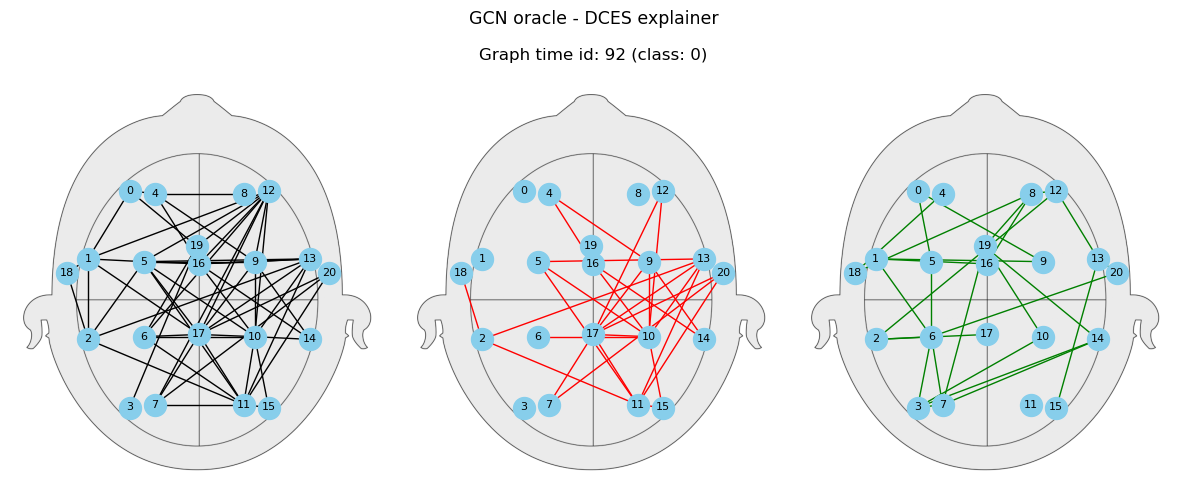

In [36]:
img_path = "EEG_utils\\nodi-vuoto.png"

output_path = "..\\..\\explainability\GRETEL-repo\\output\\video\\evoluzione_sottografi_" + file_name.split('.')[0] + ".mp4"

filtered_pairs = [
    pair for pair in eval_manager._evaluators[0].get_instance_explanation_pairs()
    if (pair[0].patient_id == patient_id and pair[0].record_id == record_id)
]

create_animation(filtered_pairs, eval_manager, img_path, fixed_positions, output_path, file_name)

## _______________________________________________________________

In [37]:
import datetime

now = datetime.datetime.now()
print("Ultima esecuzione completa:", now.strftime("%d/%m/%Y, ore %H:%M"))

Ultima esecuzione completa: 05/03/2025, ore 16:37
